In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# Any results you write to the current directory are saved as output.

In [ ]:
lines=pd.read_csv("/content/Hindi_English_Truncated_Corpus.csv")

In [ ]:
lines['source'].value_counts()

,count
source,
tides,50000
ted,39881
indic2012,37726


In [ ]:
lines=lines[lines['source']=='ted']

In [ ]:
lines.head(20)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
23,ted,This changed slowly,धीरे धीरे ये सब बदला
26,ted,were being produced.,उत्पन्न नहीं कि जाती थी.
30,ted,"And you can see, this LED is going to glow.","और जैसा आप देख रहे है, ये एल.ई.डी. जल उठेगी।"
32,ted,"to turn on the lights or to bring him a glass of water,","लाईट जलाने के लिए या उनके लिए पानी लाने के लिए,"
35,ted,Can you imagine saying that?,क्या आप ये कल्पना कर सकते है


In [ ]:
pd.isnull(lines).sum()

,0
source,0
english_sentence,0
hindi_sentence,0


In [ ]:
lines=lines[~pd.isnull(lines['english_sentence'])]

In [ ]:
lines.drop_duplicates(inplace=True)

* ### Let us pick any 25000 rows from the dataset.

In [ ]:
lines=lines.sample(n=25000,random_state=42)
lines.shape

(25000, 3)

In [ ]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [ ]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))


In [ ]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.head()

,source,english_sentence,hindi_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापिता कौन हैं वह कौन है _END
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END
122330,ted,and its not as hard as you think integrate climate solutions into all of your innovations,START_ और जितना आपको लगता है यह उतना कठिन नहीं हैअपने सभी नवाचारों में जलवायु समाधान को एकीकृत करें _END


In [ ]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [ ]:
len(all_eng_words)

14030

In [ ]:
len(all_hindi_words)

17540

In [ ]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))

In [ ]:
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापिता कौन हैं वह कौन है _END,11,16
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6
122330,ted,and its not as hard as you think integrate climate solutions into all of your innovations,START_ और जितना आपको लगता है यह उतना कठिन नहीं हैअपने सभी नवाचारों में जलवायु समाधान को एकीकृत करें _END,16,20


In [ ]:
lines[lines['length_eng_sentence']>30].shape

(0, 5)

In [ ]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

In [ ]:
lines.shape

(24774, 5)

In [ ]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [ ]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(14030, 17540)

In [ ]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens += 1 #for zero padding

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
lines = shuffle(lines)
lines.head(10)

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
28027,ted,that we personally may know very little about,START_ जिन मे बारे में व्यक्तिगत रूप से हम बहुत कम जानते हैं _END,8,14
4351,ted,the only people who dont experience shame,START_ सिर्फ उन्ही लोगों को शर्म महसूस नहीं होती _END,7,10
17820,ted,if you look at a map of india today,START_ यदि आप वर्तमान भारत के नक्शे को देखें _END,9,10
80248,ted,when they first came to antarctica,START_ जब वह पहली बार अंटार्कटिका आए थे _END,6,9
111873,ted,but if more and more of these readings start making sense,START_ लेकिन अगर और भी एसे अनुवाद समझ बनाना शुरू कर दें _END,11,13
12178,ted,is they repeat again and again,START_ कि वो बार बार दुहराते हैं _END,6,8
115423,ted,i was in south africa on safari,START_ मैं द अफ्रीका में जंगल की सैर पर था _END,7,11
67124,ted,but has it ever occurred to you that the reason you feel sleepy,START_ पर क्या आपने कभी यह सोचा है कि आपको अगर झपकी आती है _END,13,15
116033,ted,i gave a quiz questions,START_ मैनें एक टेस्ट लिया सवालों का। _END,5,8
96837,ted,there are a million pictures,START_ यहाँ लाखों तस्वीरें है _END,5,6


### Split the data into train and test

In [ ]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((19819,), (4955,))

### Let us save this data

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')


In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:  # Infinite loop to keep generating batches for training
        for j in range(0, len(X), batch_size):  # Loop through the dataset in steps of batch_size
            # Initialize empty arrays for encoder input, decoder input, and decoder target data
            encoder_input_data = np.zeros((batch_size, max_length_src), dtype='float32')  # Encoder input sequences
            decoder_input_data = np.zeros((batch_size, max_length_tar), dtype='float32')  # Decoder input sequences
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens), dtype='float32')  # One-hot encoded target sequences

            # Loop through each input-output pair in the current batch
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                # Process the input text (source sequence) for the encoder
                for t, word in enumerate(input_text.split()):
                    if word in input_token_index: # Add check for OOV words
                        encoder_input_data[i, t] = input_token_index[word]  # Map word to token index for encoder input

                # Process the target text (target sequence) for the decoder
                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split()) - 1:  # Exclude the last word from decoder input
                        if word in target_token_index: # Add check for OOV words
                            decoder_input_data[i, t] = target_token_index[word]  # Map word to token index for decoder input
                    if t > 0:  # Skip the first word in the target sequence for decoder target (it's the "START_" token)
                        # One-hot encode the target sequence for the decoder output (excluding "START_" token)
                        if word in target_token_index: # Add check for OOV words
                            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

            # Yield the batch, where the encoder input data, decoder input data are the inputs
            # and decoder target data is the output for training the model
            yield((encoder_input_data, decoder_input_data), decoder_target_data)

### Encoder-Decoder Architecture

In [ ]:
latent_dim=300

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))  # Input layer, where shape=(None,) indicates variable length sequences
enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)  # Embedding layer for input sequences
encoder_lstm = LSTM(latent_dim, return_state=True, use_cudnn=False)  # LSTM layer with latent_dim as the output size, disable cuDNN
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)  # LSTM outputs and states (h and c)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]  # Encoder's final states (used for decoder initialization)

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))  # Input layer for the decoder
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)  # Embedding layer for decoder inputs
dec_emb = dec_emb_layer(decoder_inputs)  # Apply embedding layer to decoder inputs

# Set up the LSTM layer for the decoder
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, use_cudnn=False)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer to output probabilities over the decoder vocabulary (softmax)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model: encoder_inputs and decoder_inputs will output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 300) │  4,209,300 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 300) │  5,262,300 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 300),     │    721,200 │ embedding_2[0][0… │
│                     │ (None, 300),      │            │ not_equal_2[0][0] │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_3[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │  5,279,841 │ lstm_3[0][0]      │
│                     │ 17541)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,193,841 (61.77 MB)

 Trainable params: 16,193,841 (61.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [ ]:
history = model.fit(x = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - loss: 5.2899 - val_loss: 5.6630
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - loss: 5.1118 - val_loss: 5.6044
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - loss: 4.9337 - val_loss: 5.5472
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 4.7564 - val_loss: 5.5099
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - loss: 4.5782 - val_loss: 5.4869
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - loss: 4.4019 - val_loss: 5.4830
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 267ms/step - loss: 4.2226 - val_loss: 5.4720
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - loss: 4.0613 - val_loss: 5.4574
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - loss: 3.9025 - val_loss: 5.4717
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - loss: 3.7448 - val_loss: 5.4727
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - loss: 3.5883 - val_loss: 5.4887
Epoch 12

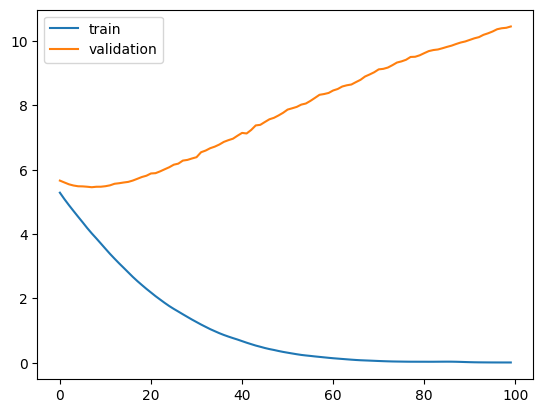

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model.save_weights('nmt_weights.weights.h5')

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input English sentence: these girls are also working in big construction companies
Actual Hindi Translation:  ये लड़कियां बड़े निर्माण संगठनो में काम कर रही हैं 
Predicted Hindi Translation:  ये लड़कियां बड़े निर्माण संगठनो में काम कर रही


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input English sentence: and the third night he would give it two more folds
Actual Hindi Translation:  और तीसरी रात फ़िर वो उसे दो बार मोड देता था 
Predicted Hindi Translation:  और तीसरी रात फ़िर वो उसे दो बार मोड देता था 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input English sentence: and of course the everpresent media
Actual Hindi Translation:  और हां हर जगह मौजूद मीडिया 
Predicted Hindi Translation:  और हां हर जगह मौजूद मीडिया 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input English sentence: but when you tell someone your goal and they acknowledge it
Actual Hindi Translation:  किन्तु जब आप अपना लछ्य किसी व्यक्ति को बताते हैं और वह व्यक्ति आपकी सराहना करता है 
Predicted Hindi Translation:  किन्तु जब आप अपना लछ्य किसी व्यक्ति को बताते है


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input English sentence: the age is years
Actual Hindi Translation:  यह साल पुराना है। 
Predicted Hindi Translation:  यह साल पुराना है। 
